# Segmentierung mittels morphologischer Rekonstruktion

Ein vielversprechender Ansatz, um eine stabile Segmentierung für die Objektdefinition zu erhalten, könnte die morphologische Rekonstruktion sein.

Die Grundidee besteht darin auf ein Bild, das so genannte Markierungsbild, immer wieder die Dilationsoperation (Ausdehnung der Kanten) anzuwenden, bis die Kontur des Markierungsbildes unter ein zweites Bild, das so genannte Maskenbild passt. Bildlich gedacht, breiten sich die Gipfel des Markierungsbildes aus. Somit können Gipfel, aber auch Löcher in einem Bild gefunden werden.

Das Paket scikit-image bietet im Modul morphology die Funktion reconstruction, um die morphologische Rekonstruktion durchzuführen.

In [9]:
import numpy as np
import xarray as xr

from skimage import morphology
from scipy import ndimage as ndi

from l15_msevi import msevi as msv

import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap(vmin=210,vmax=300)

import fixed_colourbar as fc

Wir laden uns mal SEVIRI-Daten um den Ansatz auszuprobieren.

In [3]:
s = msv.MSevi(time=dt.datetime(2013,6,18,12,0),region=((216, 456), (1676, 2076)),scan_type='rss',chan_list=["IR_108","HRV"])
s.lonlat()
s.rad2bt()
s.rad2refl()

Region suggests use of hdf file


## Finden von Gipfeln

Für die HRV-Daten wäre es interessant die Gipfel im Bild zu finden. Dazu benötigen wie ein Markierungsbild und ein Maskenbild. Da wir uns für die Gipfel interessieren, können wir als Markierungsbild das globale Minimum des Bildes nehmen, das wir rekonstruieren wollen. Allerdings benötigen wir einen schmalen Rand mit Originalwerten, damit wir die Dilation durchführen können.

In [4]:
marker_image = np.copy(s.ref['HRV'])
#marker_image[1:-1,1:-1] = s.ref['HRV'].min()
marker_image[1:-1,1:-1] = 0

Als Maske können wir das Bild selbst benutzen.

In [5]:
mask_image = np.copy(s.ref['HRV'])

Die Rekonstruktion sollte uns dann die Bereiche mit lokalen Minima liefern.

In [6]:
rec = morphology.reconstruction(marker_image,mask_image,method='dilation')

Wenn wir diese dann vom Originalbild abziehen, sollten wir die Gipfel erhalten.

In [7]:
peaks = s.ref['HRV'] - rec

Dann sehen wir uns das Ergebnis doch mal an.

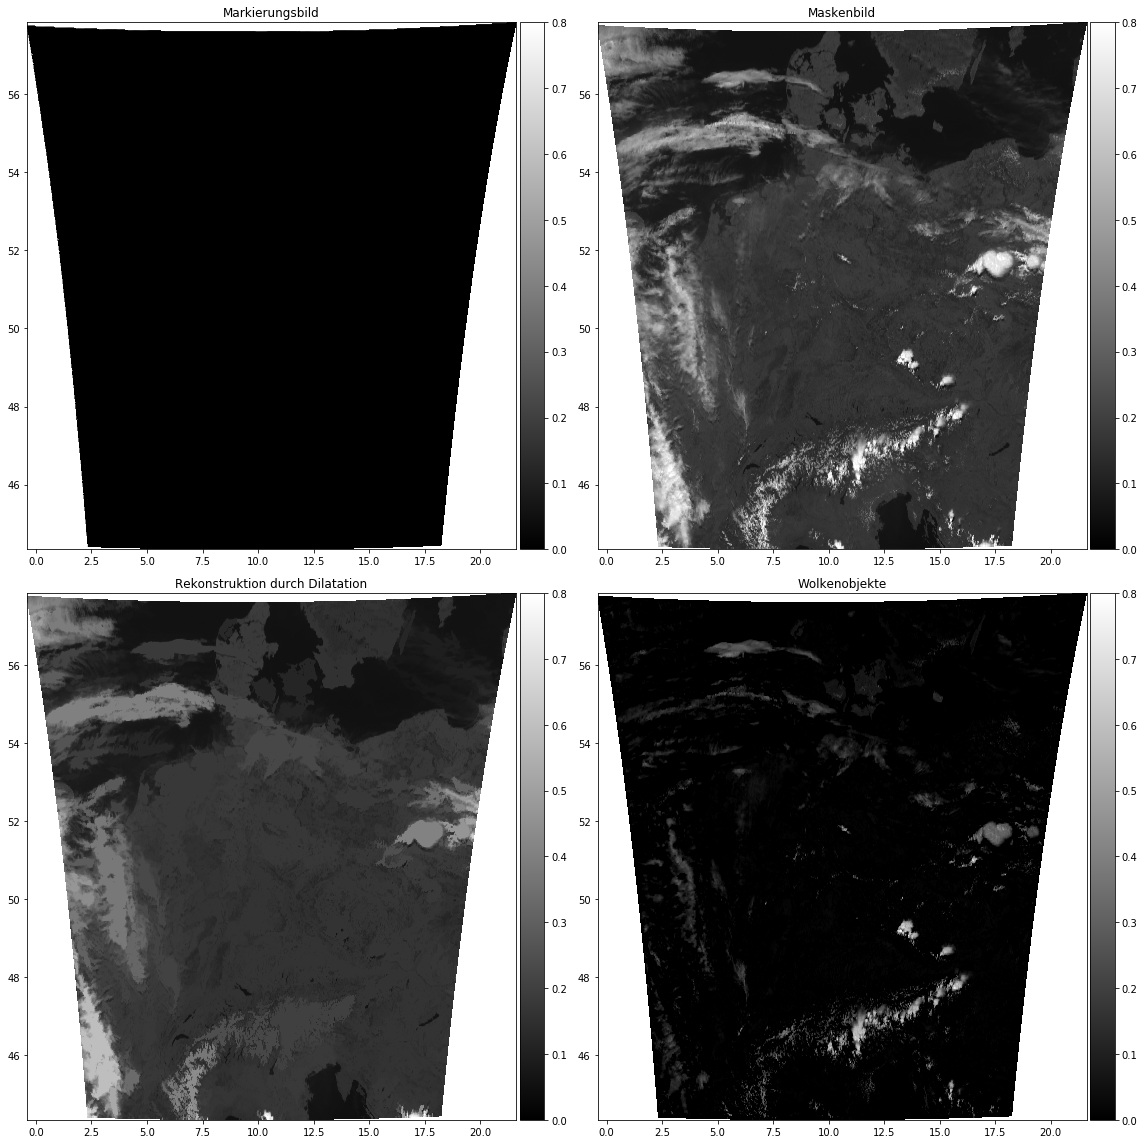

In [20]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
marks_plot = ax[0,0].pcolormesh(s.hlon,s.hlat,marker_image,vmin=0,vmax=0.8,cmap='gray')
ax[0,0].set_title(u"Markierungsbild")
fc.colourbar(marks_plot)
mask_plot = ax[0,1].pcolormesh(s.hlon,s.hlat,np.clip(mask_image,0,1), vmin=0,vmax=0.8,cmap='gray')
ax[0,1].set_title(u"Maskenbild")
fc.colourbar(mask_plot)
rec_plot = ax[1,0].pcolormesh(s.hlon,s.hlat,np.clip(rec,0,1),vmin=0,vmax=0.8,cmap='gray')
ax[1,0].set_title(u"Rekonstruktion durch Dilatation")
fc.colourbar(rec_plot)
peak_plot = ax[1,1].pcolormesh(s.hlon,s.hlat,np.clip(peaks,0,1), vmin=0, vmax=0.8, cmap='gray')
ax[1,1].set_title(u"Wolkenobjekte")
fc.colourbar(peak_plot)
plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/segmentierungsansatz.png")

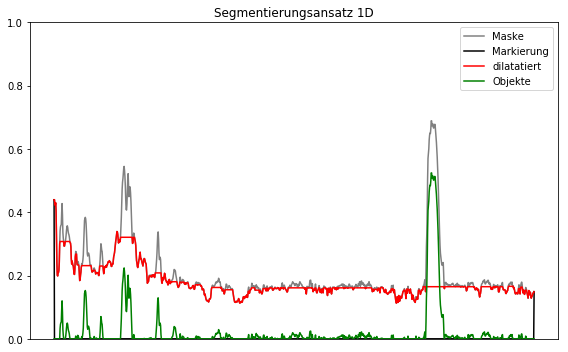

In [21]:
yslice = 450
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(s.ref['HRV'][yslice], '0.5', label='Maske',)
ax.plot(marker_image[yslice], 'k', label='Markierung')
ax.plot(rec[yslice], 'r', label='dilatatiert')
ax.plot(peaks[yslice], 'g', label='Objekte')
ax.set_ylim(-0.2, 2)
ax.set_title('Segmentierungsansatz 1D')
ax.set_xticks([])
ax.set_ylim((0,1))
ax.legend()
plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/segmentierungsansatz_1d.pdf")

Das Ergebnis der Gifpel sieht ziemlich gut aus. Allerdings werden auch Inseln als Gipfel gefunden. Hier hilft wahrscheinlich eine Wolkenmaske weiter.

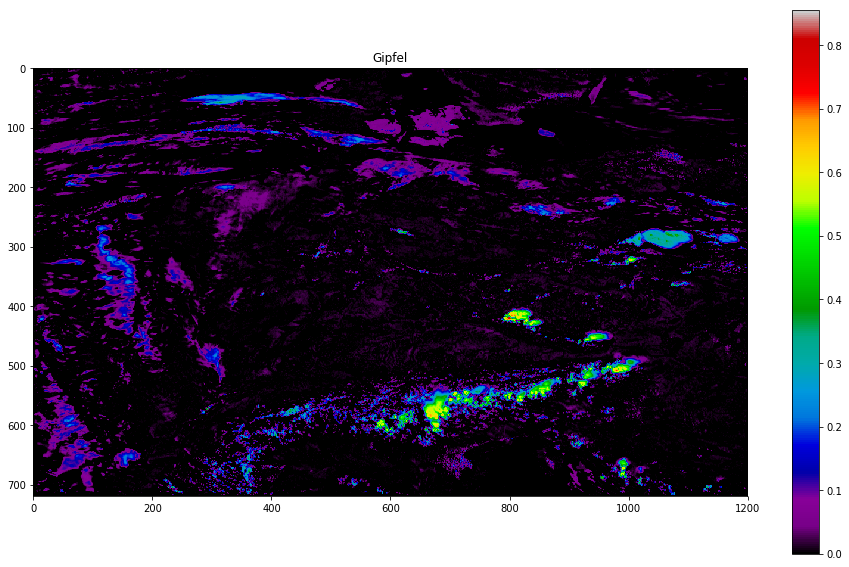

In [19]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
peak_plot = ax.imshow(peaks,vmin=np.min(peaks),vmax=np.max(peaks),cmap='nipy_spectral')
ax.set_title(u"Gipfel")
fig.colorbar(peak_plot)

In [25]:
h = 0.3
seed = s.ref['HRV'] - h
dilated = morphology.reconstruction(seed, mask_image, method='dilation')
hdome = mask_image - dilated

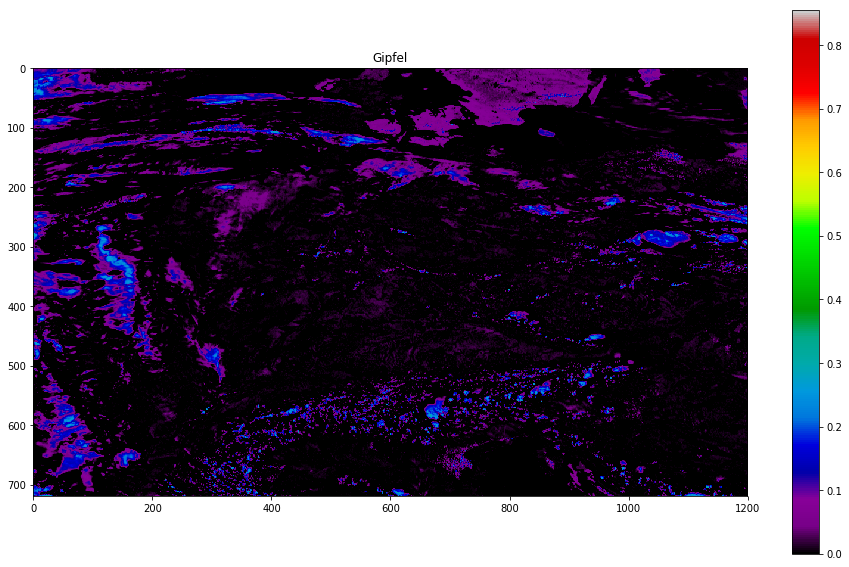

In [26]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
peak_plot = ax.imshow(hdome,vmin=np.min(peaks),vmax=np.max(peaks),cmap='nipy_spectral')
ax.set_title(u"Gipfel")
fig.colorbar(peak_plot)

In [29]:
yslice = 410

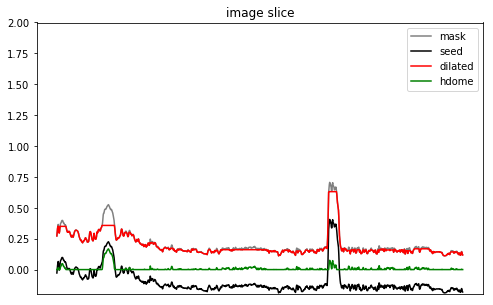

In [30]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(s.ref['HRV'][yslice], '0.5', label='mask')
ax.plot(seed[yslice], 'k', label='seed')
ax.plot(dilated[yslice], 'r', label='dilated')
ax.plot(hdome[yslice], 'g', label='hdome')
ax.set_ylim(-0.2, 2)
ax.set_title('image slice')
ax.set_xticks([])
ax.legend()

In [72]:
seed = ndi.gaussian_filter(np.copy(s.ref['HRV']),3)
seed[1:-1,1:-1] = 0
dilated = morphology.reconstruction(seed, ndi.gaussian_filter(mask_image,3), method='dilation')
hdome = mask_image - dilated

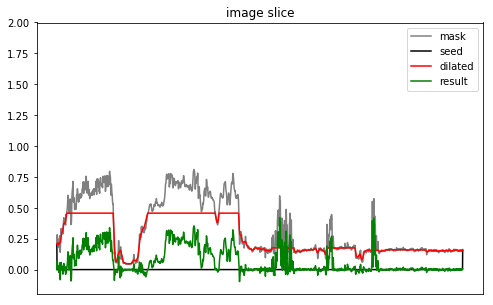

In [73]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(s.ref['HRV'][yslice], '0.5', label='mask')
ax.plot(seed[yslice], 'k', label='seed')
ax.plot(dilated[yslice], 'r', label='dilated')
ax.plot(hdome[yslice], 'g', label='result')
ax.set_ylim(-0.2, 2)
ax.set_title('image slice')
ax.set_xticks([])
ax.legend()

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
marks_plot = ax[0,0].imshow(marker_image)
ax[0,0].set_title(u"Markierungsbild")
mask_plot = ax[0,1].imshow(np.clip(mask_image,0,1), vmin=0,vmax=1,cmap='gray')
ax[0,1].set_title(u"Maskenbild")
rec_plot = ax[1,0].imshow(np.clip(rec,0,1),vmin=0,vmax=1,cmap='gray')
ax[1,0].set_title(u"Rekonstruktion durch Dilatation")
peak_plot = ax[1,1].imshow(np.clip(peaks,0,1), vmin=0, vmax=1, cmap='gray')
ax[1,1].set_title(u"Gipfel")

## Finden von Löchern

Das Finden von Löchern funktioniert nach dem gleichen Prinzip, wie das Finden von Gipfeln, nur, dass das Makierungsbild mit dem Maximum des Ausgangsbildes gefüllt wird und in der morphologischen Rekonstruktion nicht dilatiert sondern erodiert wird.

In [14]:
marker_image = np.copy(s.bt['IR_108'])
marker_image[1:-1,1:-1] = s.bt['IR_108'].max()

Als Maske benutzen wir wieder das Ausgangsbild.

In [15]:
mask_image = np.copy(s.bt['IR_108'])

Dann führen wir wieder die Rekonstruktion durch, nur, dass wir jetzt dilatieren, sondern erodieren.

In [16]:
rec = morphology.reconstruction(marker_image,mask_image,method='erosion')

Die Löcher erhalten wir, indem wir das Rekonstruktionsergebnis vom Ausgangsbild abziehen.

In [17]:
holes = s.bt['IR_108'] - rec

Dann sehen wir uns das Ergebnis doch mal an.

Text(0.5,1,u'L\xf6cher')

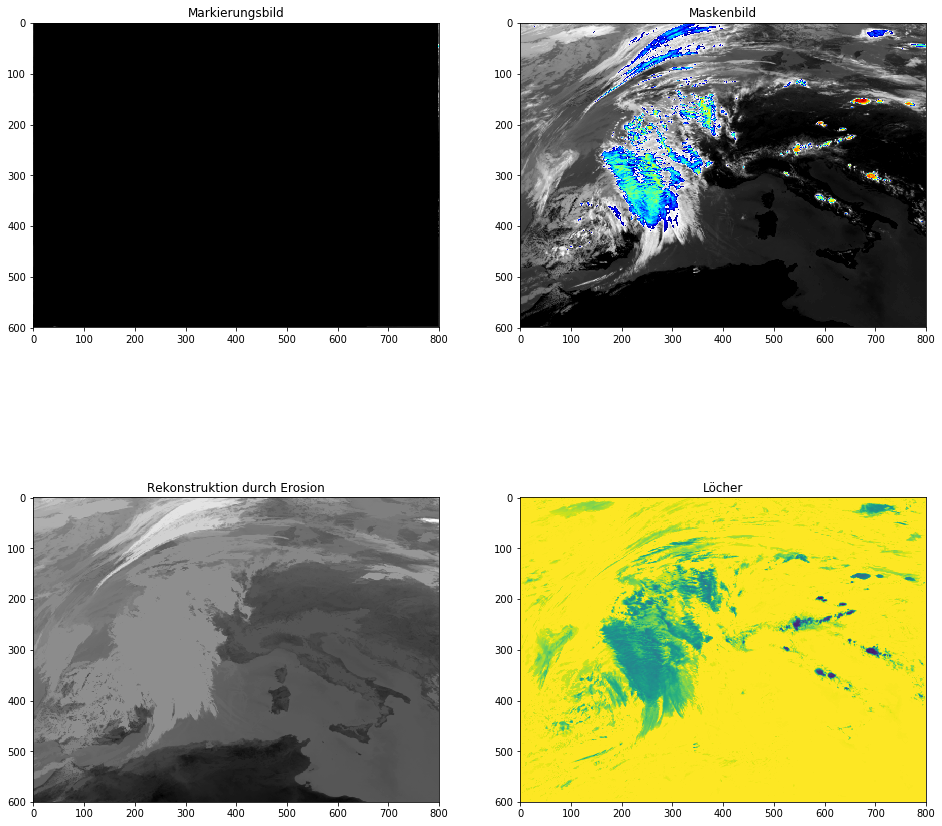

In [22]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
marks_plot = ax[0,0].imshow(marker_image,vmin=210,vmax=300,cmap=emap)
ax[0,0].set_title(u"Markierungsbild")
mask_plot = ax[0,1].imshow(mask_image,vmin=210,vmax=300,cmap=emap)
ax[0,1].set_title(u"Maskenbild")
rec_plot = ax[1,0].imshow(rec,vmin=np.min(rec),vmax=np.max(rec),cmap='gray_r')
ax[1,0].set_title(u"Rekonstruktion durch Erosion")
peak_plot = ax[1,1].imshow(holes)
ax[1,1].set_title(u"Löcher")

Das Ergebnis sieht auch sehr brauchbar aus. Allerdings ist wahrscheinlich noch ein Schwellwert für die "Lochtiefe" notwendig um wirklich konvektive Objekte zu finden.

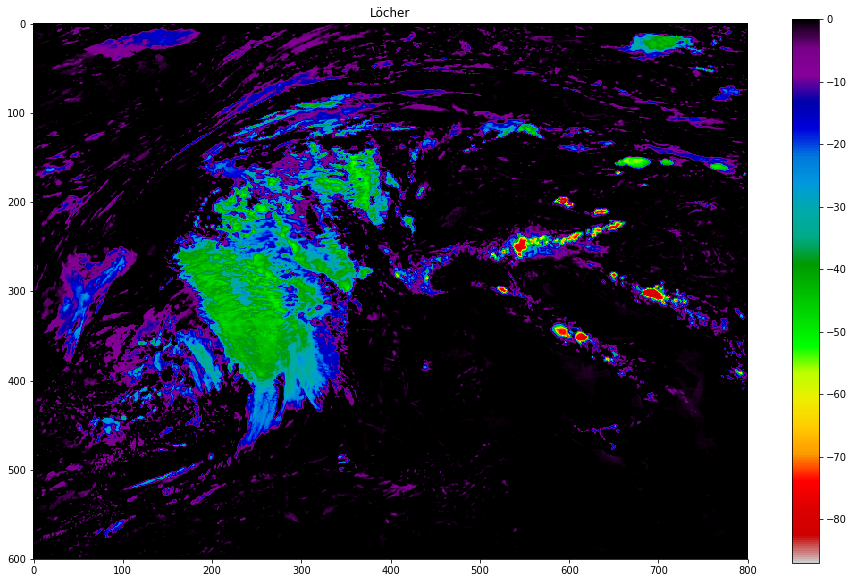

In [23]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
hole_plot = ax.imshow(holes,vmin=np.min(holes),vmax=np.max(holes),cmap='nipy_spectral_r')
ax.set_title(u"Löcher")
fig.colorbar(hole_plot)

In [24]:
ir_masked = np.ma.masked_where(holes==0,s.bt['IR_108'])

(array([4.6000e+01, 8.9000e+01, 1.4800e+02, 2.7800e+02, 4.4700e+02,
        8.4100e+02, 1.8940e+03, 3.8610e+03, 4.2460e+03, 4.1270e+03,
        4.3470e+03, 3.6420e+03, 4.3800e+03, 3.9510e+03, 4.3660e+03,
        4.3080e+03, 5.3390e+03, 5.7590e+03, 6.0730e+03, 6.1210e+03,
        6.8310e+03, 7.8500e+03, 7.9260e+03, 8.2280e+03, 8.7350e+03,
        1.1902e+04, 1.2716e+04, 1.3024e+04, 1.4170e+04, 1.6753e+04,
        1.9174e+04, 2.0217e+04, 1.5410e+04, 1.3440e+04, 1.7178e+04,
        2.3239e+04, 5.4575e+04, 3.8783e+04, 2.0656e+04, 1.9739e+04,
        1.2327e+04, 6.0500e+03, 5.2780e+03, 5.3600e+03, 5.9320e+03,
        8.8020e+03, 8.4540e+03, 7.9520e+03, 3.5430e+03, 1.2060e+03]),
 array([210.3300675 , 212.59918833, 214.86830916, 217.13742998,
        219.40655081, 221.67567164, 223.94479247, 226.2139133 ,
        228.48303413, 230.75215496, 233.02127579, 235.29039662,
        237.55951745, 239.82863828, 242.0977591 , 244.36687993,
        246.63600076, 248.90512159, 251.17424242, 253.44336325

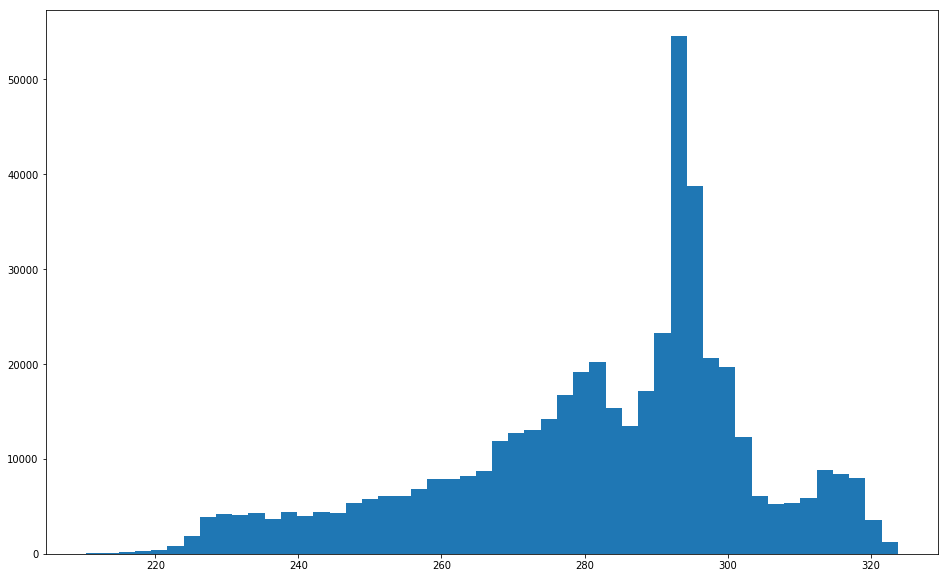

In [25]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.hist(ir_masked.ravel(),bins=50)

Die Verteilung der Helligkeitstemperaturen für die Gipfel im Bild ist ziemlich Breit. Die meisten Pixel sind im Bereich um 295 K. Das sind wahrscheinlich warme Wasserwolken. Dann gibt es auch Pixel mit Werten deutlich über 300 K. Das sind wahrscheinlich keine Wolken mehr, sondern Bodenmerkmale. Der Bereich mit 280 K und darunter ist wahrscheinlich der Bereich der interessant ist.

In [26]:
masked_holes = np.copy(holes)
masked_holes[s.bt['IR_108']>300] = 0

Text(0.5,1,u'Differenz maskierte L\xf6cher, L\xf6cher')

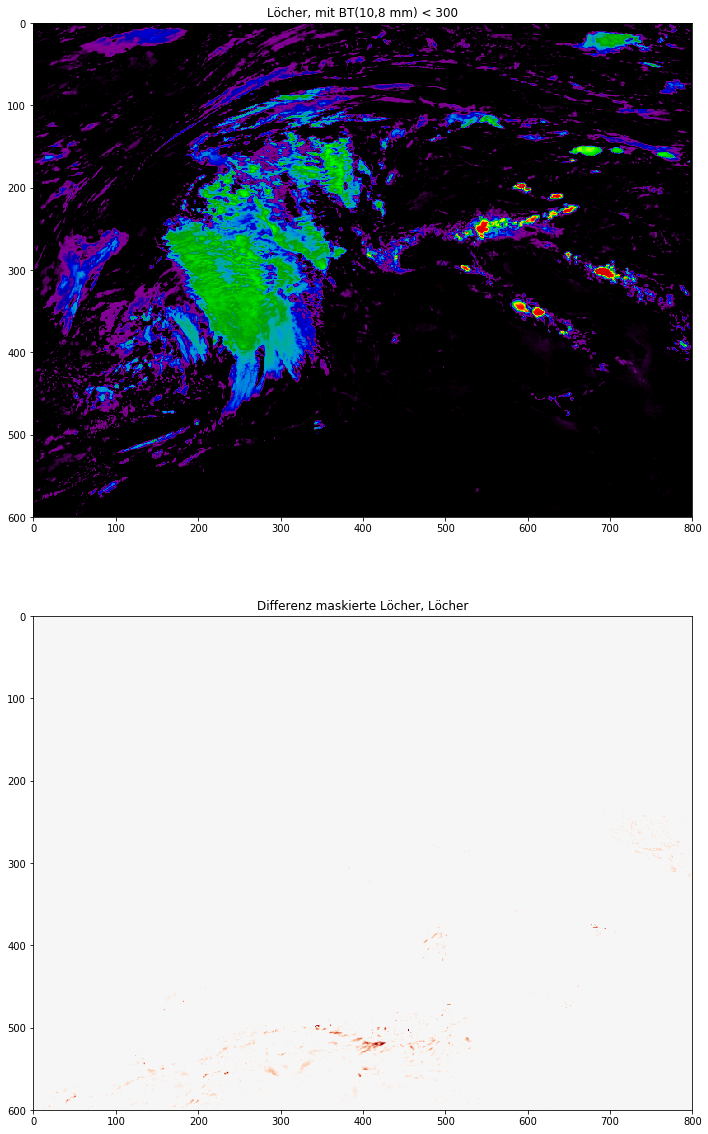

In [27]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
hole_plot = ax[0].imshow(masked_holes,vmin=np.min(masked_holes),vmax=np.max(masked_holes),cmap='nipy_spectral_r')
ax[0].set_title(u"Löcher, mit BT(10,8 mm) < 300")
ax[1].imshow(masked_holes - holes, vmin=-10,vmax=10,cmap='RdBu_r')
ax[1].set_title(u"Differenz maskierte Löcher, Löcher")

Die Werte mit über 300 K finden sich nur in Nordafrika und im Mittelmeerraum und scheinen Bodenmerkmale darzustellen. Sie sind also uninteressant und können ausmaskiert werden.

In [28]:
masked_holes = np.copy(holes)
masked_holes[s.bt['IR_108']>295] = 0
masked_holes[s.bt['IR_108']<280] = 0

Text(0.5,1,u'Differenz maskierte L\xf6cher, L\xf6cher')

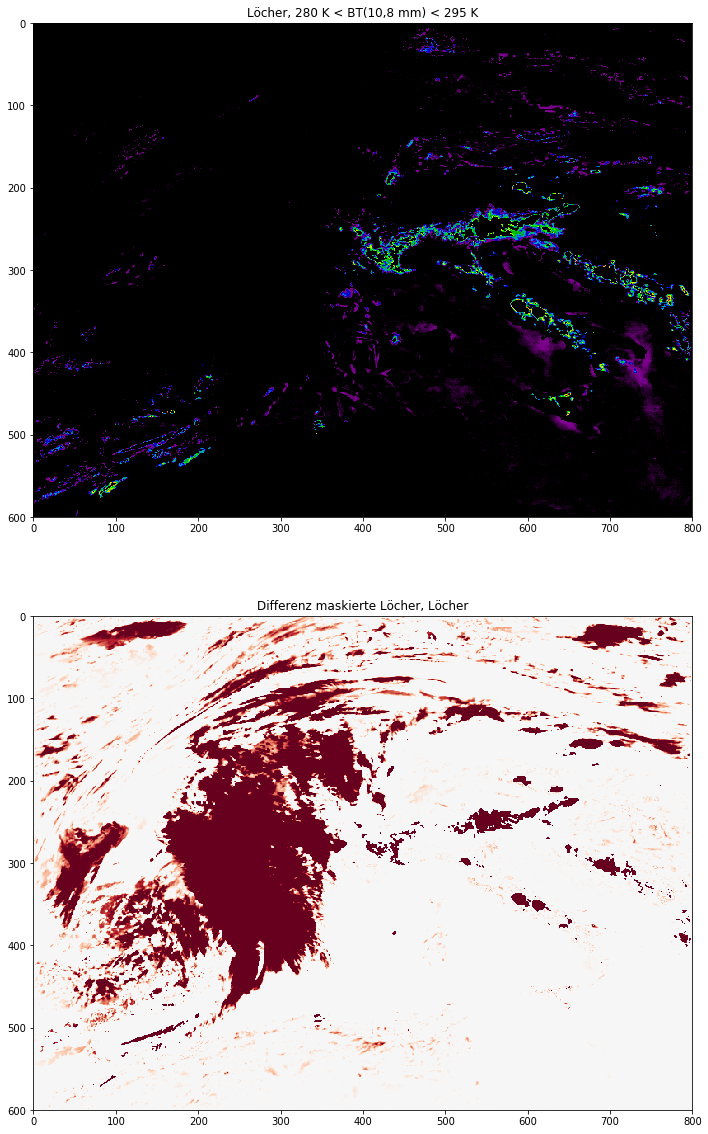

In [29]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
hole_plot = ax[0].imshow(masked_holes,vmin=np.min(masked_holes),vmax=np.max(masked_holes),cmap='nipy_spectral_r')
ax[0].set_title(u"Löcher, 280 K < BT(10,8 mm) < 295 K")
ax[1].imshow(masked_holes - holes, vmin=-10,vmax=10,cmap='RdBu_r')
ax[1].set_title(u"Differenz maskierte Löcher, Löcher")

Der Bereich zwischen 280 K und 295 K sind wahrscheinlich hauptsächlich warem Wasserwolken und Randbereiche der konvektiven Wolken. Der Bereich ist also durchaus interessant.

In [30]:
masked_holes = np.copy(holes)
masked_holes[s.bt['IR_108']>280] = 0

Text(0.5,1,u'Differenz maskierte L\xf6cher, L\xf6cher')

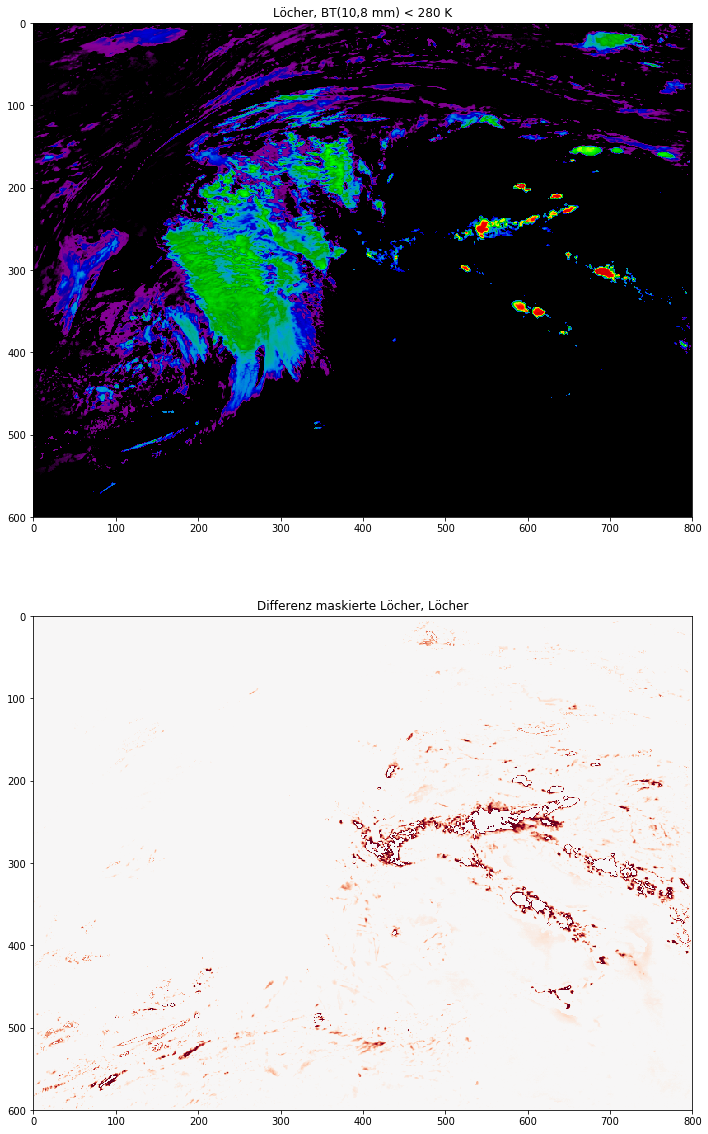

In [31]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
hole_plot = ax[0].imshow(masked_holes,vmin=np.min(masked_holes),vmax=np.max(masked_holes),cmap='nipy_spectral_r')
ax[0].set_title(u"Löcher, BT(10,8 mm) < 280 K")
ax[1].imshow(masked_holes - holes, vmin=-10,vmax=10,cmap='RdBu_r')
ax[1].set_title(u"Differenz maskierte Löcher, Löcher")

Der Bereich mit Werten kleiner 280 K ist der Kernbereich der konvektiven Wolken und frontale Bewölkung.

In [32]:
masked_holes = np.copy(holes)
masked_holes[s.bt['IR_108']>240] = 0

Text(0.5,1,u'Differenz maskierte L\xf6cher, L\xf6cher')

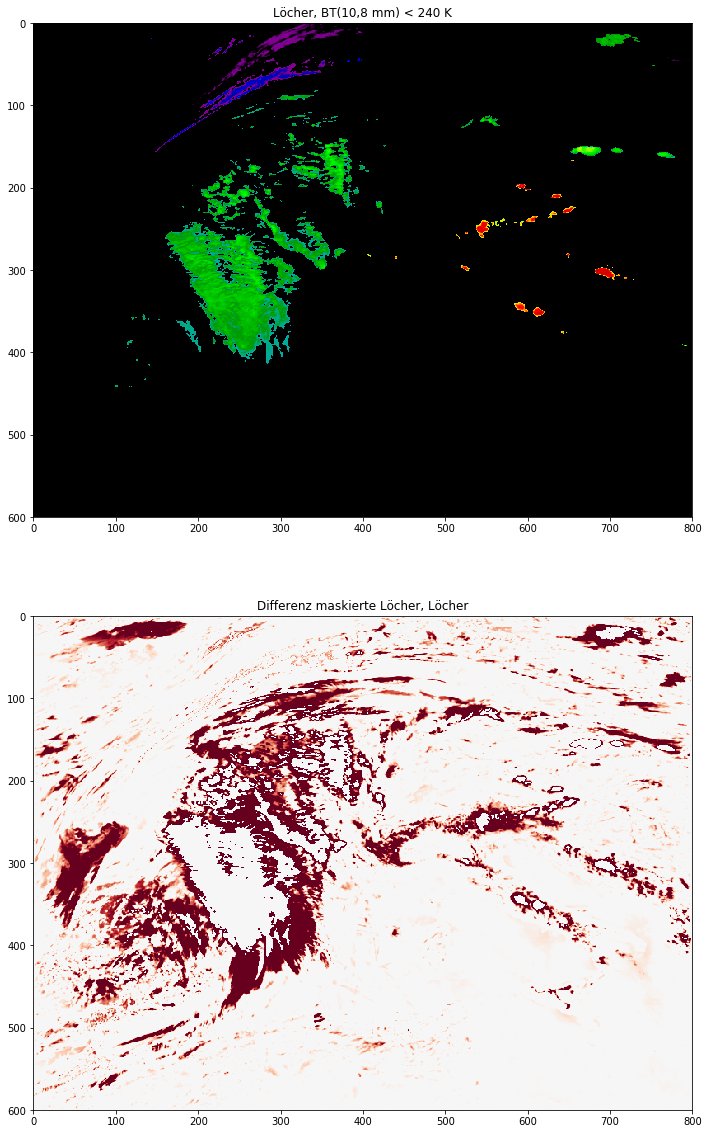

In [33]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
hole_plot = ax[0].imshow(masked_holes,vmin=np.min(masked_holes),vmax=np.max(masked_holes),cmap='nipy_spectral_r')
ax[0].set_title(u"Löcher, BT(10,8 mm) < 240 K")
ax[1].imshow(masked_holes - holes, vmin=-10,vmax=10,cmap='RdBu_r')
ax[1].set_title(u"Differenz maskierte Löcher, Löcher")

Im Bereich < 240 K bleiben nur noch hohe frontale Wolken und die konvektiven Kerne übrig. Die konvektiven Kerne haben aber deutlich höhere Lochtiefen als die frontale Bewölkung.